In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf

# Download data
data_train = yf.download('TCS.NS', start='2010-01-01', end='2020-01-01')
data_test = yf.download('TCS.NS', start='2020-01-02', end='2024-01-01')

# Use 'Close' prices for prediction
train_prices = data_train['Close'].values.reshape(-1, 1)
test_prices = data_test['Close'].values.reshape(-1, 1)

# Normalize the prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_prices)
scaled_test_prices = scaler.transform(test_prices)

# Create dataset with a look-back period
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60  # Using the past 60 days to predict the next day
X_train, Y_train = create_dataset(scaled_train_prices, look_back)
X_test, Y_test = create_dataset(scaled_test_prices, look_back)

# Reshape input for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0210 - val_loss: 0.0029
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 3.0577e-04 - val_loss: 0.0036
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 3.1724e-04 - val_loss: 0.0031
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 2.7597e-04 - val_loss: 0.0038
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 2.7850e-04 - val_loss: 0.0034
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 2.8083e-04 - val_loss: 0.0053
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.9121e-04 - val_loss: 0.0058
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 2.6707e-04 - val_loss: 0.0018
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.0219e-04 - val_loss: 0.0092
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 5.7291e-04 - val_loss: 0.0093
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 5.0444e-04 - val_loss: 0.0034
Epoch 12/100
61/61 ━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


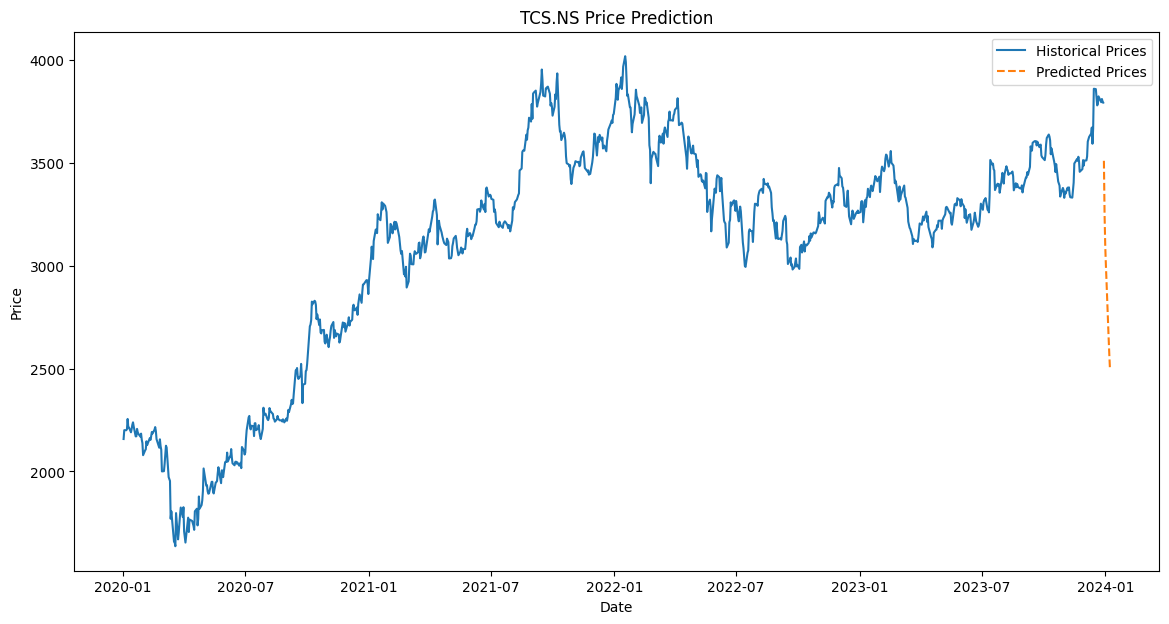

In [ ]:
# Test the model by predicting the next n days
n_days = 10  # Number of days to predict into the future
test_input = scaled_test_prices[-look_back:].reshape(1, look_back, 1)

predicted_prices = []

for _ in range(n_days):
    # Predict the next day's price
    predicted_price = model.predict(test_input)
    predicted_prices.append(predicted_price[0, 0])

    # Reshape predicted_price and update the input for the next prediction
    predicted_price_reshaped = np.reshape(predicted_price[0, 0], (1, 1, 1))
    test_input = np.append(test_input[:, 1:, :], predicted_price_reshaped, axis=1)

# Inverse transform the predictions to original scale
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Create a time range for the prediction dates
last_date = data_test.index[-1]
prediction_dates = pd.date_range(last_date, periods=n_days+1).tolist()[1:]

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data_test.index, test_prices, label='Historical Prices')
plt.plot(prediction_dates, predicted_prices, label='Predicted Prices', linestyle='--')
plt.title('TCS.NS Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
symbol='^NSEI'
data=yf.download(tickers=symbol,period='max',interval='1d')
historical_stock_data=data['Adj Close']

# instrument_key=df[df['Symbol']==symbol]['instrument_key'].values[0]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
from datetime import date
import pandas as pd
import yfinance as yf

# Download Nifty 50 data from Yahoo Finance
historical_stock_data = yf.download('^NSEI', period='max')

# Calculate daily percentage change
historical_stock_data['pct'] = historical_stock_data['Close'].pct_change()

# Extract the current year
current_year = date.today().year

# Create a list of years for the past 18 years
my_years = [current_year - i for i in range(0, 18)]

# Create a dictionary to store results
my_dict = {}

# Iterate over each year and calculate the abnormal returns
for year in my_years:
    # Filter data for the specific year and where abs percentage change > 2%
    current_year_abnorm = historical_stock_data[(historical_stock_data.index.year == year) & (abs(historical_stock_data['pct']) > 0.02)]

    # Store the DataFrame in the dictionary
    my_dict[year] = current_year_abnorm.dropna()

# Print the dictionary keys to check
for year in my_dict:
    print(f"Year: {year}, Rows: {len(my_dict[year])}")
# historical_stock_data

[*********************100%%**********************]  1 of 1 completed

Year: 2024, Rows: 6
Year: 2023, Rows: 1
Year: 2022, Rows: 17
Year: 2021, Rows: 9
Year: 2020, Rows: 42
Year: 2019, Rows: 6
Year: 2018, Rows: 6
Year: 2017, Rows: 0
Year: 2016, Rows: 11
Year: 2015, Rows: 13
Year: 2014, Rows: 4
Year: 2013, Rows: 20
Year: 2012, Rows: 14
Year: 2011, Rows: 31
Year: 2010, Rows: 14
Year: 2009, Rows: 65
Year: 2008, Rows: 104
Year: 2007, Rows: 18


In [2]:
import yfinance as yf

# Define the ticker symbol
ticker = 'HAL'  # Replace with your desired ticker symbol

# Get the stock object
stock = yf.Ticker(ticker)

# Get available expiration dates
exp_dates = stock.options
print("Available Expiration Dates:", exp_dates)

# Select an expiration date
exp_date = exp_dates[0]  # You can select any date from the available dates

# Get options chain for the selected expiration date
options_chain = stock.option_chain(exp_date)

# Call and Put options data
calls = options_chain.calls
puts = options_chain.puts

print("Calls Data:\n", calls)
print("Puts Data:\n", puts)


Available Expiration Dates: ('2024-08-16', '2024-08-23', '2024-08-30', '2024-09-06', '2024-09-13', '2024-09-20', '2024-09-27', '2024-10-18', '2025-01-17', '2025-06-20', '2025-12-19', '2026-01-16', '2026-12-18')
Calls Data:
         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0   HAL240816C00020000 2024-06-24 16:58:31+00:00    20.0      14.60  11.05   
1   HAL240816C00023000 2024-08-07 18:07:42+00:00    23.0       7.85   0.00   
2   HAL240816C00025000 2024-08-07 18:07:43+00:00    25.0       5.85   0.00   
3   HAL240816C00026000 2024-08-01 16:02:14+00:00    26.0       7.40   0.00   
4   HAL240816C00027000 2024-08-08 17:49:44+00:00    27.0       4.20   0.00   
5   HAL240816C00027500 2024-08-05 14:17:18+00:00    27.5       3.35   0.00   
6   HAL240816C00029000 2024-08-07 13:43:02+00:00    29.0       2.36   0.00   
7   HAL240816C00029500 2024-08-06 19:30:21+00:00    29.5       1.93   0.00   
8   HAL240816C00030000 2024-08-09 18:34:46+00:00    30.0       1.36   0.00

In [ ]:
my_dict[2024]

,Open,High,Low,Close,Adj Close,Volume,pct
Date,,,,,,,
2024-01-17,21647.250000,21851.500000,21550.449219,21571.949219,21571.949219,456000,-0.020894
2024-06-03,23337.900391,23338.699219,23062.300781,23263.900391,23263.900391,569400,0.032542
2024-06-04,23179.500000,23179.500000,21281.449219,21884.500000,21884.500000,1006100,-0.059294
2024-06-05,22128.349609,22670.400391,21791.949219,22620.349609,22620.349609,638500,0.033624
2024-06-07,22821.849609,23320.199219,22789.050781,23290.150391,23290.150391,473600,0.020540
2024-08-05,24302.849609,24350.050781,23893.699219,24055.599609,24055.599609,487000,-0.026786


In [ ]:
print(predicted_prices,
prediction_dates)
data_test

[[3510.5486]
 [3246.597 ]
 [3095.199 ]
 [2998.7942]
 [2913.557 ]
 [2826.342 ]
 [2737.8645]
 [2651.8413]
 [2571.2134]
 [2497.6118]] [Timestamp('2023-12-30 00:00:00'), Timestamp('2023-12-31 00:00:00'), Timestamp('2024-01-01 00:00:00'), Timestamp('2024-01-02 00:00:00'), Timestamp('2024-01-03 00:00:00'), Timestamp('2024-01-04 00:00:00'), Timestamp('2024-01-05 00:00:00'), Timestamp('2024-01-06 00:00:00'), Timestamp('2024-01-07 00:00:00'), Timestamp('2024-01-08 00:00:00')]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,2179.949951,2179.949951,2149.199951,2157.649902,1971.202393,2380752
2020-01-03,2164.000000,2223.000000,2164.000000,2200.649902,2010.486450,4655761
2020-01-06,2205.000000,2225.949951,2187.899902,2200.449951,2010.303833,3023209
2020-01-07,2200.500000,2214.649902,2183.800049,2205.850098,2015.237671,2429317
2020-01-08,2205.000000,2260.000000,2202.050049,2255.250000,2060.368896,5197454
...,...,...,...,...,...,...
2023-12-22,3800.000000,3845.949951,3762.000000,3824.000000,3770.140381,2413058
2023-12-26,3819.850098,3834.000000,3790.149902,3795.550049,3742.091064,1285231
2023-12-27,3799.000000,3818.199951,3768.000000,3811.199951,3757.520508,1293976
